## Dependencies

In [88]:
import numpy as np
import torch as pt 
import ast
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import numpy as np
import torch.optim as optim

In [89]:
#! Check Gpu Availability
if pt.cuda.is_available():
    print("PyTorch is using GPU")
    print(f"GPU device: {pt.cuda.get_device_name(0)}")
else:
    print("PyTorch is not using GPU")


PyTorch is using GPU
GPU device: Tesla P100-PCIE-16GB


In [90]:
def load_data_labels(data_path, labels_path):
    with open(data_path, 'r') as f:
        data = [ast.literal_eval(line.strip()) for line in f]
    with open(labels_path, 'r') as f:
        labels = [ast.literal_eval(line.strip()) for line in f]
    return data, labels


In [91]:
data, labels = load_data_labels('/kaggle/input/pizza-orders/training_data_processed_1.txt','/kaggle/input/pizza-orders/train_order_category_labels_1.txt')
print(data[:5])
print(labels[:5])

[['i', 'like', 'one', 'pizza', 'with', 'red', 'onion', 'fry', 'onion', 'and', 'mozarella', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'anchovy', 'caramelize', 'red', 'onion', 'and', 'roast', 'green', 'pepper', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'applewood', 'bacon', 'grill', 'pineapple', 'and', 'shrimp', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'pesto', 'sauce', 'roast', 'pepper', 'and', 'peppperonis', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'peperronni', 'spicy', 'red', 'sauce', 'and', 'mushroom', 'without', 'thin', 'crust']]
[[2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [92]:
dev_data, dev_labels = load_data_labels('/kaggle/input/pizza-orders/dev_data_processed_1.txt', '/kaggle/input/pizza-orders/dev_order_category_labels_1.txt')
print(dev_data[:5])
print(dev_labels[:5])

[['i', 'want', 'to', 'order', 'two', 'medium', 'pizza', 'with', 'sausage', 'and', 'black', 'olive', 'and', 'two', 'medium', 'pizza', 'with', 'pepperoni', 'and', 'extra', 'cheese', 'and', 'three', 'large', 'pizza', 'with', 'pepperoni', 'and', 'sausage'], ['five', 'medium', 'pizza', 'with', 'tomato', 'and', 'ham'], ['i', 'need', 'to', 'order', 'one', 'large', 'vegetarian', 'pizza', 'with', 'extra', 'banana', 'pepper'], ['i', 'like', 'to', 'order', 'one', 'large', 'onion', 'and', 'pepper', 'pizza'], ['i', 'll', 'have', 'one', 'pie', 'along', 'with', 'pesto', 'and', 'ham', 'but', 'avoid', 'olive']]
[[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 0, 0, 0, 0, 0, 0], [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [93]:
def get_vocab_freq(data):
    vocab_freq = {}
    for d in data:
        for w in d:
            if w in vocab_freq:
                vocab_freq[w] += 1
            else:
                vocab_freq[w] = 1
    return vocab_freq
vocab_freq= get_vocab_freq(data)
print(type(vocab_freq))
def replace_with_unk(data, vocab_freq, threshold):
    unk = '<UNK>'
    data_unk = []
    for d in data:
        d_unk = [w if vocab_freq[w] >= threshold else unk for w in d]
        data_unk.append(d_unk)
    return data_unk
data = replace_with_unk(data, vocab_freq, 20)
print(data[:5])

<class 'dict'>
[['i', 'like', 'one', 'pizza', 'with', 'red', 'onion', 'fry', 'onion', 'and', 'mozarella', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'anchovy', 'caramelize', 'red', 'onion', 'and', 'roast', 'green', 'pepper', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'applewood', 'bacon', 'grill', 'pineapple', 'and', 'shrimp', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'pesto', 'sauce', 'roast', 'pepper', 'and', 'peppperonis', 'without', 'thin', 'crust'], ['i', 'like', 'one', 'pizza', 'with', 'peperronni', 'spicy', 'red', 'sauce', 'and', 'mushroom', 'without', 'thin', 'crust']]


In [94]:
vocab= set()
for d in data:
    vocab.update(d)
vocab.add('<PAD>')
print(len(vocab))
print(vocab)
word2idx = {w: i for i, w in enumerate(vocab)}

277
{'pork', 'broccoli', 'pepperoni', 'a', 'feta', 'yorker', 'regular', 'fourteen', 'it', 'pecorino', 'along', 'bacon', 'chicken', 'fl', 'napolitana', 'tea', 'stuff', 'garlic', 'up', 'eight', 'apple', 'vegan', 'that', 'top', 'arugula', 'sprite', 'll', 'can', 'peperroni', 'pizza', 'lover', 'bite', 'nine', 'deepdish', 'pellegrinos', 'hundredml', 'avoid', 'cherry', 'spice', 'two', 'new', 'chorrizo', 'pull', 'size', 'fat', 'pineapple', 'brocoli', 'order', 'add', 'everything', 'want', 'vegetarian', 'meatball', 'spinach', 'take', 'ice', 'pan', 'sauce', 'four', 'well', 'hate', 'ranch', 'six', 'american', 'm', 'oil', 'glaze', 'basil', 'grind', 'roast', 'hot', 'tuna', 'fry', 'crust', 'the', 'bean', 'without', 'thirteen', 'dr', 'let', 'grill', 'spicy', 'eleven', 'no', 'dry', 'also', 'some', 'anchovy', 'mountain', 'them', 'supreme', 'cheeseburger', 'to', 'green', 'buffalo', 'put', 'big', 'party', 'pellegrino', 'hawaiian', 'many', 'rosemary', 'little', 'do', 'five', 'low', 'cauliflower', 'meatlove

In [95]:
embedding_dim=150
input_dim=len(vocab)
output_dim=3
max_length=100

In [96]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = [self.vocab.get(word, self.vocab['<UNK>']) for word in text]
        
        return tokens, label
def collate_fn(batch):
    # batch.sort(key=lambda x: len(x[0]), reverse=True)  # Sort by sequence length
    
    sequences, labels = zip(*batch)  
    max_len = max(len(seq) for seq in sequences)  
    
    padded_sequences = []
    labels_list = []  
    
    for seq, label in zip(sequences, labels):
        padded_seq = list(seq) + [word2idx['<PAD>']] * (max_len - len(seq))  
        padded_labels = list(label) + [-1] * (max_len - len(seq))
        padded_sequences.append(pt.tensor(padded_seq))
        # print(padded_labels)
        labels_list.append(padded_labels)  
        
    
    padded_sequences = pt.stack(padded_sequences)
    labels_tensor = pt.tensor(labels_list, dtype=pt.long)  
    return padded_sequences, labels_tensor
train_dataset = TextDataset(data, labels ,word2idx, max_length)
dev_dataset = TextDataset(dev_data, dev_labels, word2idx, max_length)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [97]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, max_length):
        super(BiLSTMModel, self).__init__()
        
        #! Embedding Layer: learnable word embeddings
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        #! Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            bidirectional=True,  
            batch_first=True      #! Input shape (batch_size, seq_len)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2 , hidden_dim),
            nn.ReLU()
        )
        
        #! Output layer for each time step
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        
        packed_out, (hn, cn) = self.lstm(embedded)
        
        intermediate_output = self.fc(packed_out.data)

        output = self.output_layer(intermediate_output)  
        
        
        return output

In [98]:
model = BiLSTMModel(len(vocab), embedding_dim, 128, 1, output_dim, max_length)
model.to('cuda')


BiLSTMModel(
  (embedding): Embedding(277, 150)
  (lstm): LSTM(150, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)

In [99]:
loss_function = nn.CrossEntropyLoss(ignore_index=-1)


In [100]:
history = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

In [101]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [102]:
num_epochs =20


In [103]:
for epoch in range(num_epochs):
    model.train() 
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()  
        
        # Forward pass
        inputs = inputs.to('cuda')
        output = model(inputs)
        output_flat = output.view(-1, output_dim)
        labels_flat = labels.view(-1)
        output_flat = output_flat.to('cuda')
        labels_flat = labels_flat.to('cuda')
        loss = loss_function(output_flat, labels_flat)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()

        _, predicted = pt.max(output_flat, -1)  
        mask = labels_flat != -1
        predicted=predicted[mask]
        labels_flat=labels_flat[mask]
        correct_train_preds += (predicted == labels_flat).sum().item()
        total_train_preds += labels_flat.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train_preds / total_train_preds
    
    model.eval()  
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    
    with pt.no_grad(): 
        for inputs, labels in dev_loader:
            inputs = inputs.to('cuda')
            output = model(inputs)
            output_flat = output.view(-1, output_dim)
            labels_flat = labels.view(-1)
            output_flat = output_flat.to('cuda')
            labels_flat = labels_flat.to('cuda')
            loss = loss_function(output_flat, labels_flat)
            
            running_val_loss += loss.item()

    
            _, predicted = pt.max(output_flat, -1) 
            mask = labels_flat != -1
            predicted=predicted[mask]
            labels_flat=labels_flat[mask]
            correct_val_preds += (predicted == labels_flat).sum().item()
            total_val_preds += labels_flat.size(0)

    avg_val_loss = running_val_loss / len(dev_loader)
    val_accuracy = 100 * correct_val_preds / total_val_preds
    scheduler.step(avg_train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print("------------------------------------------------------------------------------------")
    history['train_acc'].append(train_accuracy)   
    history['dev_acc'].append(val_accuracy)
    history['train_loss'].append(avg_train_loss)
    history['dev_loss'].append(avg_val_loss)

Epoch 1/20
Training Loss: 0.0206, Training Accuracy: 99.29%
Validation Loss: 0.1116, Validation Accuracy: 96.58%
------------------------------------------------------------------------------------
Epoch 2/20
Training Loss: 0.0011, Training Accuracy: 99.98%
Validation Loss: 0.0668, Validation Accuracy: 97.98%
------------------------------------------------------------------------------------
Epoch 3/20
Training Loss: 0.0007, Training Accuracy: 99.98%
Validation Loss: 0.0552, Validation Accuracy: 98.39%
------------------------------------------------------------------------------------
Epoch 4/20
Training Loss: 0.0006, Training Accuracy: 99.99%
Validation Loss: 0.0460, Validation Accuracy: 98.55%
------------------------------------------------------------------------------------
Epoch 5/20
Training Loss: 0.0004, Training Accuracy: 99.99%
Validation Loss: 0.0429, Validation Accuracy: 98.65%
------------------------------------------------------------------------------------
Epoch 6/20

Text(0.5, 1.0, 'Training and Validation Accuracy')

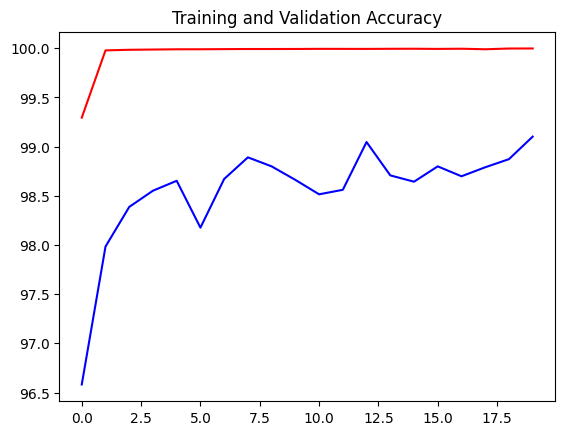

In [104]:
plt.plot(history['train_acc'], label='Training Accuracy', color='red')
plt.plot(history['dev_acc'], label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy')

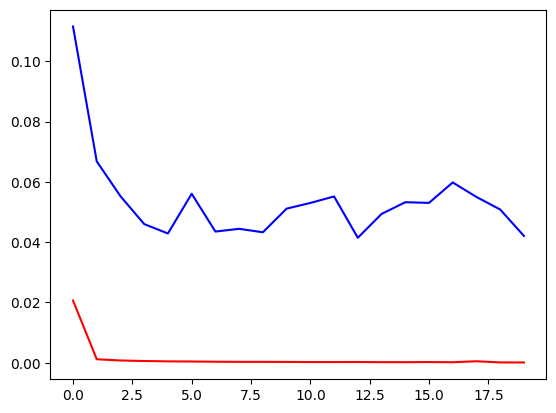

In [105]:
plt.plot(history['train_loss'], label='Training Loss', color='red')
plt.plot(history['dev_loss'], label='Validation Loss', color='blue')

In [106]:
preds_dev=[]
lbls=[]
with pt.no_grad(): 
        for inputs, labels in dev_loader:
            inputs = inputs.to('cuda')
            output = model(inputs)
            _, predicted = pt.max(output, -1) 
            for pred in predicted:
                preds_dev.append(pred)
            for lbl in labels:
                  lbls.append(lbl)
                     
# i = 0
# for pred,lbl in zip(preds_dev,lbls):
#       print(i)
#       pred=pred.tolist()
#       lbl=lbl.tolist()
#       print(pred[:len(dev_data[i])])
#       print(lbl[:len(dev_data[i])])
#       print('-------------------')
#       i+=1

In [107]:
#! calculate exact match between predicted and true labels
correct=0
i=0
for pred,lbl in zip(preds_dev,lbls):
    pred=pred.tolist()
    lbl=lbl.tolist()
    if pred[:len(dev_data[i])]==lbl[:len(dev_data[i])]:
        correct+=1
    else:
        print(i)
        print(pred[:len(dev_data[i])])
        print(lbl[:len(dev_data[i])])
        print('-------------------')
    i+=1
print(correct/len(preds_dev))

107
[2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2]
[2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2]
-------------------
109
[2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]
[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]
-------------------
129
[2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2]
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2]
-------------------
135
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
-------------------
163
[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2]
[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
-------------------
165
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2]
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
-------------------
181
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2]
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
-------------------
198
[2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 1, 1]
[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1]
-------------------
201
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 

In [108]:
preds_train=[]
lbls_train=[]
with pt.no_grad(): 
        for inputs, labels in train_loader:
            inputs = inputs.to('cuda')
            output = model(inputs)
            # print(output[0])
            _, predicted = pt.max(output, -1) 
            for pred in predicted:
                preds_train.append(pred)
            for lbl in labels:
                lbls_train.append(lbl)
i = 0
for pred,lbl in zip(preds_train,lbls_train):
      pred=pred.tolist()
      lbl=lbl.tolist()
  

In [109]:
#! calculate exact match between predicted and true labels
correct=0
i=0
for pred,lbl in zip(preds_train,lbls_train):
    pred=pred.tolist()
    lbl=lbl.tolist()
    if preds_train[:len(data[i])]==lbls_train[:len(data[i])]:
        correct+=1
    i+=1
print(correct/len(preds_dev))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!